# Лабораторная работа 1. Задача классификации

In [393]:
!pip3 install --require-virtualenv -q -r requirements.txt

In [394]:
import numpy as np
import pandas as pd
import seaborn
from scipy.spatial.distance import cdist
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Выборка

In [395]:
wine = load_wine(as_frame=True)

Данная выборка представляет собой результаты химического анализа содержания различных веществ в трёх
сортах вина, произведённого в одном регионе Италии тремя различными винодельческими предприятиями.
Далее будем называть эти предприятия 0, 1 и 2.

Анализ был проведён для 178 образцов вина, 59 из которых были получены от производителя 0, 71 - от
производителя 1, 48 - от производителя 2.

Для всех вин был проведён анализ следующих 13 признаков:

- Содержание этилового спирта (alcohol)
- Содержание яблочной кислоты (malic acid)
- Количество осадка (ash)
- Щёлочность осадка (alcalinity of ash)
- Содержание магния (magnesium)
- Содержание фенолов (total phenols)
- Содержание флавоноидов (flavanoids)
- Содержание фенолов, не являющихся флавоноидами (nonflavanoid phenols)
- Содержание проантоцианидина (proanthocyanins)
- Насыщенность цвета (colour inensity)
- Оттенок (hue)
- Содержание белка (OD280/OD315 of diluted wines)
- Содержание пролина (proline)

Имеем задачу классификации на 3 класса, каждый из которых отвечает тому или иному производителю.

## 1. Анализ выборки

### 1.1. Определение типа признаков


Каждый из этих признаков является количественным.

### 1.2. Визуальный анализ данных

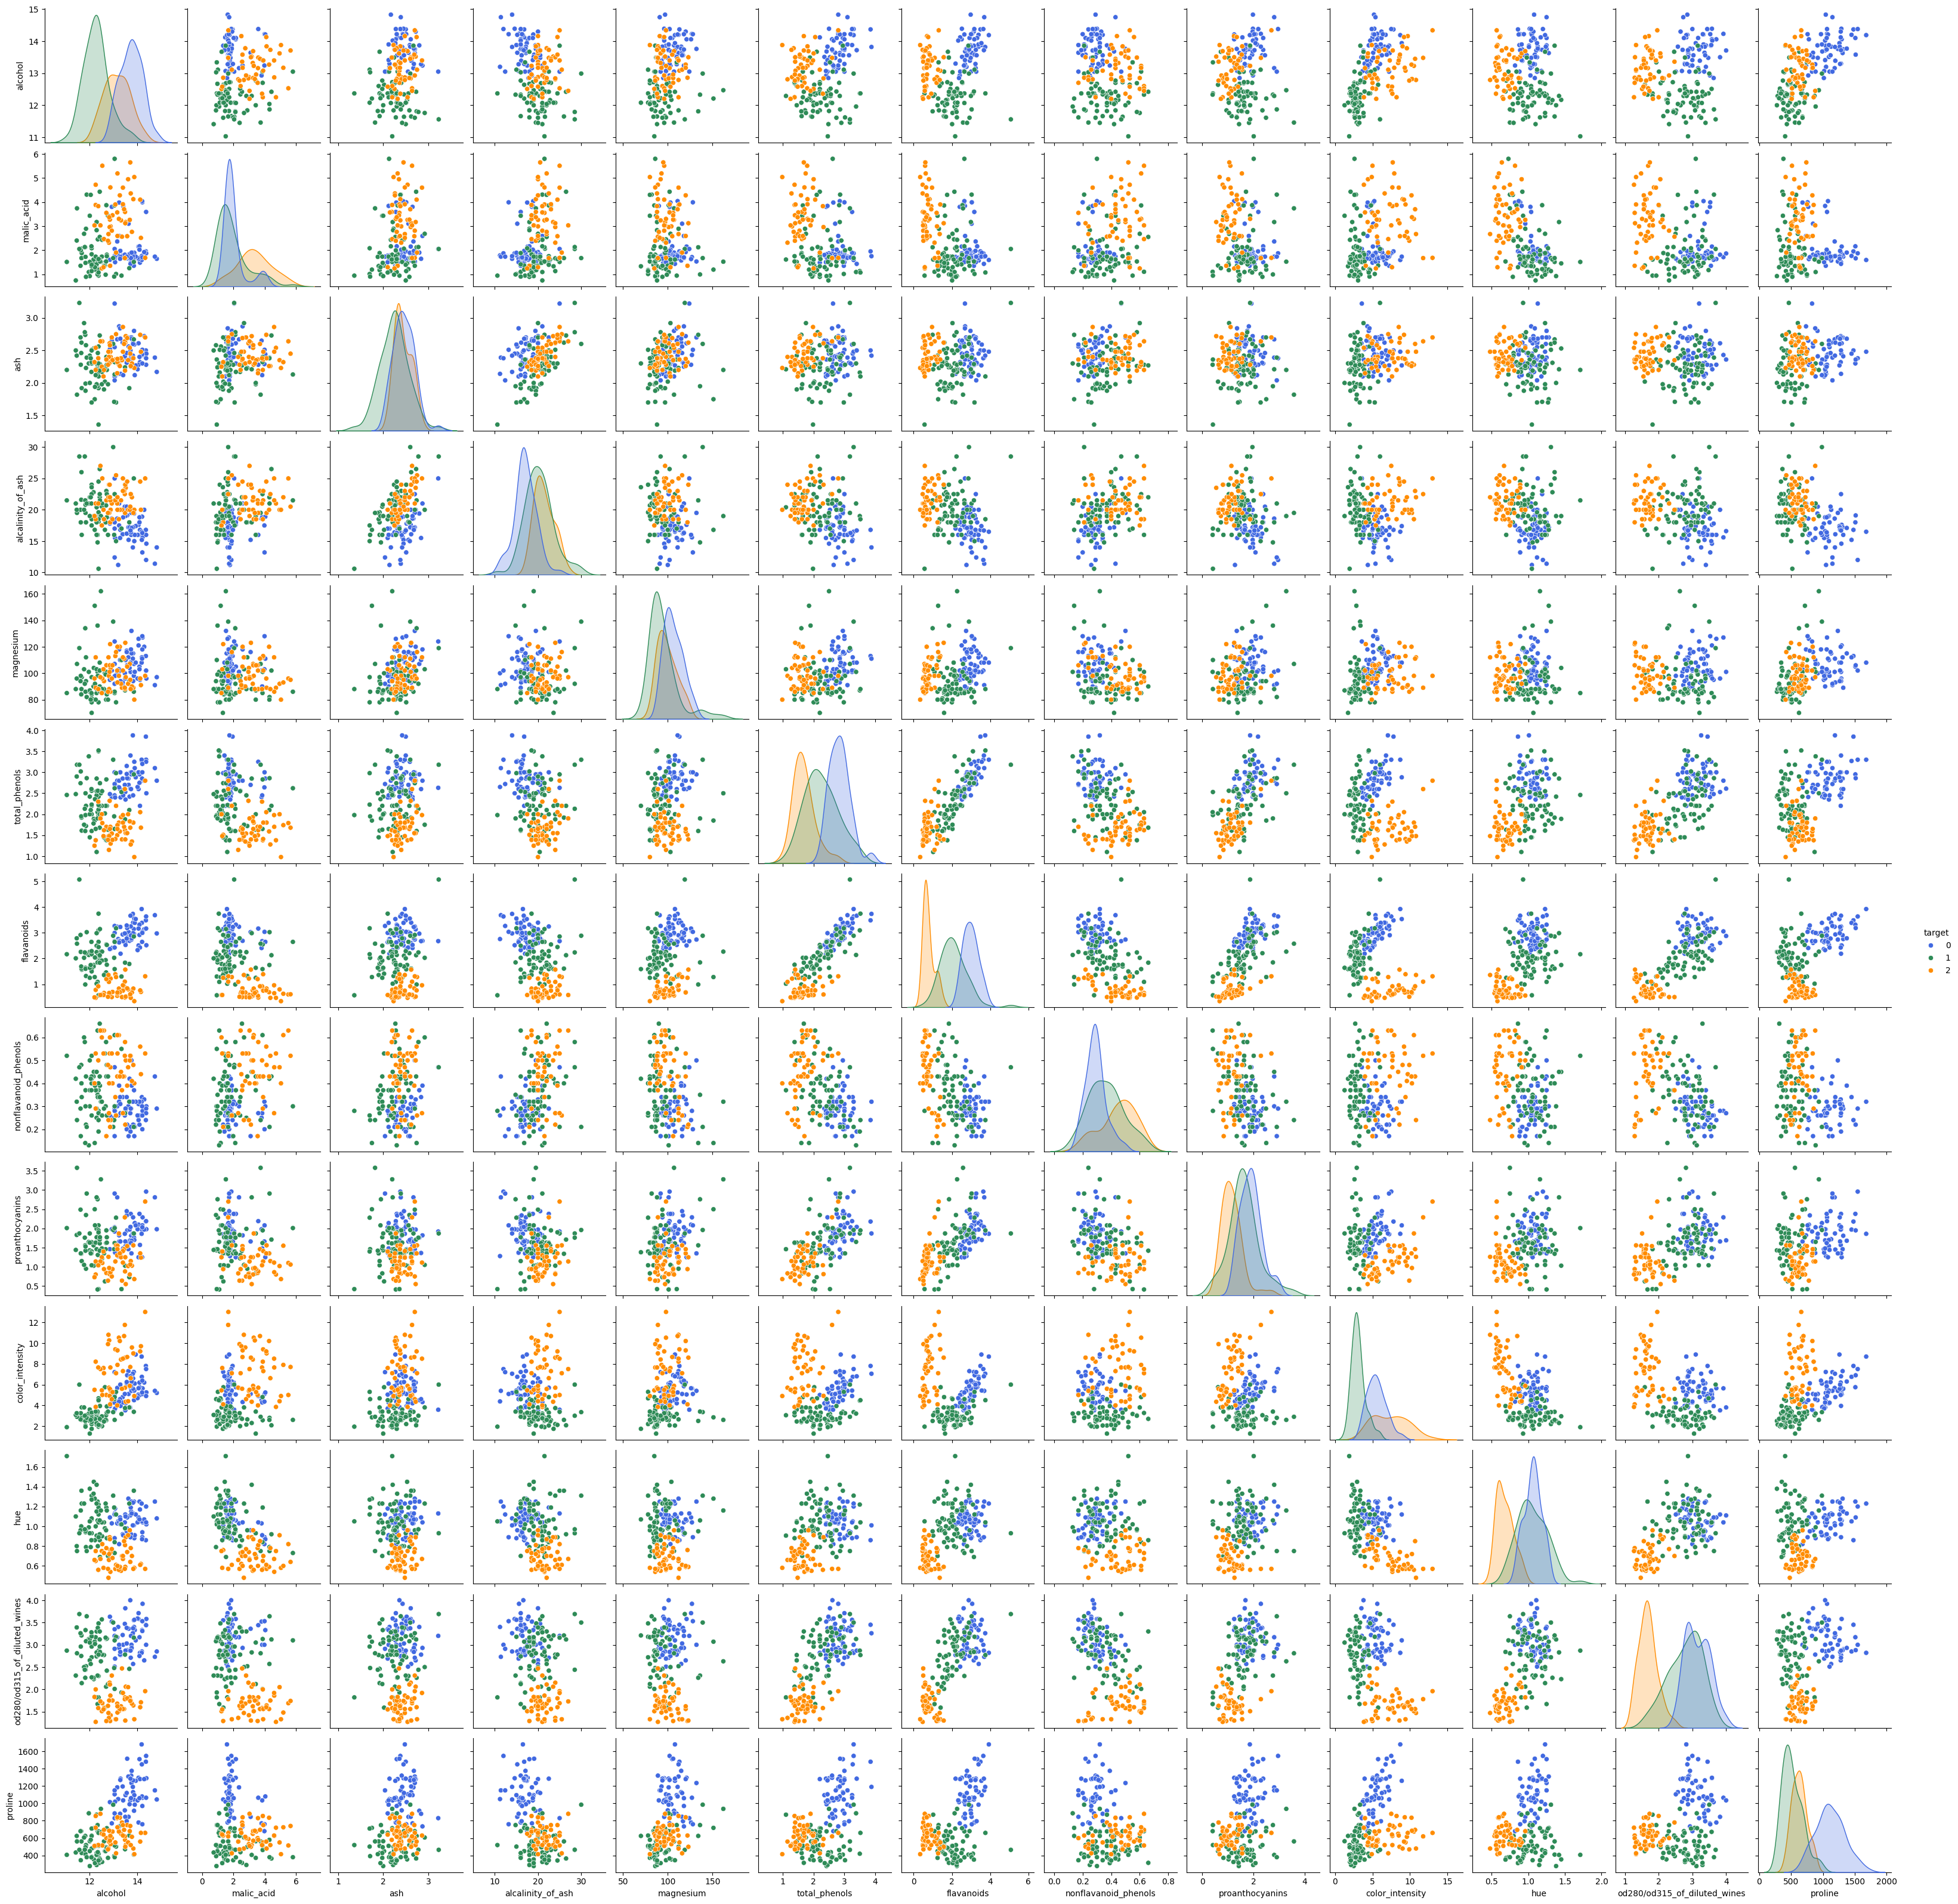

In [396]:
_ = seaborn.pairplot(data=wine.frame, hue="target", palette=["royalblue", "seagreen", "darkorange"])

Из графиков можно извлечь, что существуют пары признаков, по которым 3 класса различимы относительно
просто. Таковыми являются, например, "alcohol + hue" и "color_intensity + flavanoids". Однако
имеются и пары признаков, по которым различить классы визуально не представляется возможным.
Таковыми являются, например, "ash + magnesium" и "alcalinity_of_ash + magnesium". На субъективный
взгляд автора, преобладают пары признаков. по которым классы различимы.

## 2. Препроцессинг данных

### 2.1. Преобразование категориальных признаков в количественные

Поскольку все признаки являются количественными, нет необходимости преобразовывать их к другому типу
признаков.

### 2.2. Разделение выборки на объекты и ответы

In [397]:
y = wine.frame.target
X = wine.frame.drop("target", axis=1)

### 2.3. Нормировка признаков

In [398]:
X = StandardScaler().fit_transform(X)

### 2.4. Разделение выборки на train и test

In [399]:
kMagic = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                    random_state=kMagic)

## 3. Эксперимент для предложенных моделей

В качестве моделей автору было предложено использовать метод потенциальных функций, перцептрон и
метод опорных векторов (SVM).

### 3.1. Метод потенциальных функций

Модель в данном методе описывается следующим выражением:
\begin{equation*}
    a(x) = \text{arg} \max\limits_{y \in Y}
        \sum\limits_{i = 1}^{l} [y_i = y] K\left(\frac{\rho(x, x_i)}{h_i}\right),
\end{equation*}
где $X^l = (x_i, y_i)_{i = 1}^{l}$ -- обучающая выборка, Y -- конечное множество ответов;
$\gamma_i \geq 0$, $h_i > 0$.

#### Аналогия из электростатики


$\gamma_i$ -- величина заряда в точке $x_i$;

$h_i$ -- радиус действия потенциала с центром в точке $x_i$;

$y_i$ -- знак заряда для двухклассовой классификации, "цвет" заряда для многоклассовой классификации;

$K(r) = \dfrac{1}{1 + r}$ (добавили 1 для предотвращения деления на 0).

#### Подбор гиперпараметров

Данный метод предполагает два набора параметров: $\gamma_i$ и $h_i$. Параметры $h_i$ подбираются для
каждого объекта эмпирически, параметры $\gamma_i$ находятся в ходе обучения.

Таким образом, $h_i$ являются гиперпараметрами.

Для упрощения решения положим $\forall i \in \{1, \ldots, l\} \hookrightarrow h_i = h$.
Варьированием $h$ получим несколько моделей, а затем выберем лучшую.

#### Регуляризация

Для метрических методов классификации, к коим относится метод потенциальных функций, регуляризация
не предполагается.

#### Алгоритм обучения

- Инициализируем все $\gamma_i = 0$.
- Повторять:

    - Выбрать очередную пару $(x_i, y_i) \in X^l$.
    - Если $a(x_i) \neq y_i$, то $\gamma_i = \gamma_i + 1$

- Пока процесс не сойдётся.

#### Реализация модели

In [400]:
class PotentialFunctions:

    def __init__(self, h):
        self.X = None
        self.Y = None
        self.gamma = None
        self.h = h

    def __K(self, r):
        return 1 / (1 + r)

    def predict(self, X):
        w = (self.gamma * self.__K(cdist(X, self.X) / self.h)).T
        scores = []
        for y in np.unique_values(self.Y):
            scores.append(np.sum(w[np.where(self.Y==y)[0]], axis=0))
        return np.argmax(np.vstack(scores), axis=0)

    def fit(self, X, Y, epoch=10):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.gamma = np.zeros_like(Y)
        for _ in range(epoch):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gamma[i] += 1

#### Применение модели

In [401]:
H = list(np.linspace(0.01, 10.0, 100))

accuracy = []
predictions = []
for h in H:
    model = PotentialFunctions(h)
    model.fit(X_train, y_train)
    predictions.append(model.predict(X_test))
    accuracy.append(accuracy_score(y_test, predictions[-1]))

i, max_acc = max(enumerate(accuracy), key=lambda pair : pair[1])
print(f"Optimal h: {H[i]:.2f}")
print(f"Prediction of the optimal model: {predictions[i]}")
print(f"Test answers:                    {y_test.to_numpy()}")
print(f"Accuracy: {max_acc}")

Optimal h: 0.41
Prediction of the optimal model: [0 0 2 0 1 0 1 2 1 2 0 2 0 1 0 1 1 1 0 1 0 1 1 2 2 2 1 1 1 0 0 1 2 0 0 0]
Test answers:                    [0 0 2 0 1 0 1 2 1 2 0 2 0 1 0 1 1 1 0 1 0 1 1 2 2 2 1 1 1 0 0 1 2 0 0 0]
Accuracy: 1.0


### 3.2. Метод опорных векторов

Для задачи бинарное классификации метод формулируется следующим образом. Имеется прямая задача:
\begin{equation*}
    \begin{cases}
        w = \sum\limits_{i = 1}^{l} \lambda_i y_i x_i \\
        w_0 = \langle w, x_i \rangle - y_i,\ \forall i \in \{1,\ \ldots,\ l\}
    \end{cases}
\end{equation*}

Коэффициенты $\lambda_i$ находятся из решения двойственной задачи:
\begin{equation*}
    \begin{cases}
        -\sum\limits_{i = 1}^{l}\lambda_i +
        \dfrac{1}{2}\sum\limits_{i = 1}^{l}\sum\limits_{j = 1}^{l}
            \lambda_i \lambda_j y_i y_j K(x_i, x_j) \to \min\limits_{\lambda} \\
        \sum\limits_{i = 1}^{l} \lambda_{i}y_i = 0 \\
        0 \leq \lambda_i \leq C,\ i \in \{1,\ \ldots,\ l\},
    \end{cases}
\end{equation*}
где $K$ -- ядро, то есть $K : X \times X \to \mathbb{R}$,
$K(x, x') = \langle \psi(x), \psi(x') \rangle$ при некотором $\psi: X \to H$, где $H$ -- гильбертово
пространство.

Линейный классификатор при этом имеет вид:
\begin{equation*}
    a(x, w) = \text{sign}(\langle w, x \rangle - w_0)
\end{equation*}

#### Подбор гиперпараметров

Гиперпараметром для данного метода являются константа ядро $K$. В зависимости от ядра могут
добавляться дополнительные гиперпараметры.

Полиномиальное ядро зависит от гиперпараметров $\gamma$, $r$, $d$ и имеет вид:
\begin{equation*}
    K(x_1, x_2) = (\gamma \cdot x_1^T x_2 + r)^d
\end{equation*}

Сигмоидное ядро зависит от гиперпараметров $\gamma$, $r$ и имеет вид:
\begin{equation*}
    K(x_1, x_2) = \text{tanh}(\gamma \cdot x_1^T x_2 + r)
\end{equation*}

Ядро RBF зависит от гиперпараметра $\gamma$ имеет вид:
\begin{equation*}
    K(x_1, x_2) = \text{exp}(-\gamma \|x_1 - x_2\|^2)
\end{equation*}

Подбор наилучших гиперпараметров среди заданных осуществляется автоматически классом `GridSearchCV`.

#### Регуляризация

В модели `SVC` используется $L_2$ регуляризация, то есть к функции потерь добавляется
$L_2$-норма вектора параметров с некоторым коэффициентом:
\begin{equation*}
    \mathcal{L}(x_i, w) + \frac{1}{2C}\|w\|^2 \to \min\limits_{w}
\end{equation*}

Величину коэффициента $C$ можно регулировать, так как она является одним из параметров
конструктора. Таким образом, подбор оптимальной величины $C$ будем осуществлять тем же методом,
что и подбор гиперпараметров.

In [402]:
kDefaultC = 1.0

svm_search = GridSearchCV(estimator=SVC(), n_jobs=-1, param_grid={
    # hyperparameters
    "gamma" : np.linspace(0.001, 0.1, 100),
    "degree" : np.arange(2, 6), # d
    "coef0" : np.linspace(-5, 5, 11), # r
    "kernel" : ("linear", "poly", "rbf", "sigmoid"),
    # regularization parameter
    "C" : np.geomspace(kDefaultC / 10, kDefaultC * 100, 4),
})

svm_search.fit(X_train, y_train)
prediction = svm_search.predict(X_test)
score = accuracy_score(y_test, prediction)

print(f"Optimal parameters: {svm_search.best_params_}")
print(f"Prediction of the optimal model: {prediction}")
print(f"Test answers:                    {y_test.to_numpy()}")
print(f"Accuracy of the optimal model: {score}")

Optimal parameters: {'C': np.float64(0.1), 'coef0': np.float64(-3.0), 'degree': np.int64(3), 'gamma': np.float64(0.038), 'kernel': 'poly'}
Prediction of the optimal model: [0 0 2 0 1 0 1 2 1 2 0 2 0 1 0 1 1 1 0 1 0 1 1 2 2 2 1 1 1 0 0 1 2 0 0 0]
Test answers:                    [0 0 2 0 1 0 1 2 1 2 0 2 0 1 0 1 1 1 0 1 0 1 1 2 2 2 1 1 1 0 0 1 2 0 0 0]
Accuracy of the optimal model: 1.0


### 3.3. Перцептрон

Перцептрон -- полносвязная нейронная сеть

#### Подбор гиперпараметров

Гиперпараметрами для перцептрона можно считать число скрытых слоёв, размеры скрытых слоёв
(hidden_layer_sizes), функция активации для скрытых слоёв (activation), а также метод решения задачи
минимизации эмпирического риска.

Подбор наилучших гиперпараметров среди заданных осуществляется автоматически классом `GridSearchCV`.

#### Регуляризация

В модели `MLPClassifier` используется $L_2$ регуляризация, то есть к функции потерь добавляется
$L_2$-норма вектора параметров с некоторым коэффициентом:
\begin{equation*}
    \mathcal{L}(x_i, w) + \frac{\alpha}{2}\|w\|^2 \to \min\limits_{w}
\end{equation*}

Величину коэффициента $\alpha$ можно регулировать, так как она является одним из параметров
конструктора. Таким образом, подбор оптимальной величины $\alpha$ будем осуществлять тем же методом,
что и подбор гиперпараметров.

In [403]:
kNFeatures = X.shape[1]
kMaxIter = 10000 # enough for all solvers to converge
kDefaultAlpha = 0.0001

perceptron_search = GridSearchCV(estimator=MLPClassifier(max_iter=kMaxIter), n_jobs=-1, param_grid={
    # hyperparameters
    "hidden_layer_sizes" : [(), (kNFeatures), (kNFeatures,)*2, (kNFeatures,)*3],
    "activation" : ["logistic", "tanh", "relu"],
    "solver" : ["lbfgs", "sgd", "adam"],
    # regularization parameter
    "alpha" : np.linspace(kDefaultAlpha, kDefaultAlpha * 10, 10)
})

perceptron_search.fit(X_train, y_train)
prediction = perceptron_search.predict(X_test)
score = accuracy_score(y_test, prediction)

print(f"Optimal parameters: {perceptron_search.best_params_}")
print(f"Prediction of the optimal model: {prediction}")
print(f"Test answers:                    {y_test.to_numpy()}")
print(f"Accuracy of the optimal model: {score}")

Optimal parameters: {'activation': 'relu', 'alpha': np.float64(0.00039999999999999996), 'hidden_layer_sizes': (13, 13, 13), 'solver': 'lbfgs'}
Prediction of the optimal model: [0 0 2 0 1 0 1 2 1 2 0 2 0 1 0 1 1 1 0 1 0 1 1 2 2 2 1 1 1 0 0 1 2 0 0 0]
Test answers:                    [0 0 2 0 1 0 1 2 1 2 0 2 0 1 0 1 1 1 0 1 0 1 1 2 2 2 1 1 1 0 0 1 2 0 0 0]
Accuracy of the optimal model: 1.0


## 4. Выводы

Все 3 модели показали одинаково отличные результаты, верно классифицировав каждый объект из тестовой
выборки. Полагаю, это связано с тем, что выборка имеет относительно небольшой объём, вследствие чего
маловероятно переобучение, а также классы хорошо различимы "на глаз".

Таким образом, отдать предпочтение той или иной модели, основываясь на предсказаниях на тестовой
выборке, не представляется возможным, однако стоит отметить, что модель метода потенциальных функций
обучается с наибольшей скоростью.